### DAS npy format

**Reference**: 

Please refer to https://github.com/ethanfwilliams/OSGW_interferometry_tutorial/blob/main/01_visualize_data.py


**Purposes**
1. Load and explore DAS data

2. Plot raw time-domain signal over space

3. Compute and plot f-k spectrum (frequency – wavenumber)

4. Convert f-k spectrum to f-c spectrum (frequency - phase velocity)

5. Compute and plot frequency content vs. distance (spectral evolution)

6. Analyze SVD on f-k spectrum (data reduction)

In [1]:
# Import necessary dependencies
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load DAS data
file_path = '../data/das/Fs1Hz_dx10m_Belgium_data.npy'
data = np.load(file_path)  # Shape: (nx, ns)

In [3]:
# Define acquisition parameters
nx = 1000       # Number of channels (spatial points)
ns = 4200       # Number of time samples
fs = 1          # Sampling rate in Hz 
dx = 10         # Channel spacing in meters

In [4]:
# Create distance and time axis arrays
x = np.arange(nx) * dx      # Distance axis in meters
t = np.arange(ns) / fs      # Time axis in seconds

In [5]:
# Subplot 1: Raw DAS Data

# Define spatial and temporal window to zoom in on raw data
xmin, xmax = 0, 500         # meters
tmin, tmax = 1000, 1200     # seconds

# Index selection using logical masks
idx_x = np.logical_and(x >= xmin, x <= xmax)
idx_t = np.logical_and(t >= tmin, t <= tmax)

# Extract subset of data for visualization
data_slice = data[np.ix_(idx_x, idx_t)]  # Shape: (len(x), len(t))
xx = x[idx_x]
tt = t[idx_t]

**FK Spectrum in Decibels**

The FK spectrum magnitude in decibels is computed as:

$$
\text{FK}_{\text{dB}} = 20 \cdot \log_{10}\left( \left| \text{FFT2}(x, t) \right| + \epsilon \right)
$$

Where:
- $ \text{FFT2}(x, t) $ is the 2D Fourier Transform of the data.
- $ | \cdot | $ denotes the magnitude.
- $ \epsilon = 10^{-12} $ is a small value added to avoid $\log_{10}(0)$.


**Theoretical Dispersion Curve: Ocean Surface Gravity Waves (OSGW)**

The theoretical dispersion relation for OSGWs in water of depth $ h $ is given by:

$$
f(k) = \frac{1}{2\pi} \sqrt{g \cdot 2\pi |k| \cdot \tanh(2\pi |k| h)}
$$

Where:
- $ f(k) $ is the wave frequency (Hz)
- $ k $ is the wavenumber (1/m)
- $ g = 9.8 \, \text{m/s}^2 $ is gravitational acceleration
- $ h $ is the water depth (m)
- $ \tanh $ is the hyperbolic tangent function

This models the dispersion of surface gravity waves in finite-depth water.

In [22]:
# Subplot 2: f-k Spectrum

# Full FK transform window (wider than first plot)
xmin_fk, xmax_fk = 0, 10000
tmin_fk, tmax_fk = 0, 600

idx_x_fk = np.logical_and(x >= xmin_fk, x <= xmax_fk)
idx_t_fk = np.logical_and(t >= tmin_fk, t <= tmax_fk)

data_fk = data[np.ix_(idx_x_fk, idx_t_fk)]
xx_fk = x[idx_x_fk]
tt_fk = t[idx_t_fk]

# Perform 2D FFT
fk_spectrum = np.fft.fftshift(np.fft.fft2(data_fk))
fk_spectrum_db = 20 * np.log10(np.abs(fk_spectrum) + 1e-12)  # Avoid log(0)

# Frequency and Wavenumber axes for FK plot
freqs = np.fft.fftshift(np.fft.fftfreq(len(tt_fk), d=1. / fs))  # Hz
wavenumbers = np.fft.fftshift(np.fft.fftfreq(len(xx_fk), d=dx))  # 1/m

# Theoretical dispersion curve: Ocean Surface Gravity Waves (OSGW)
h = 20  # Water depth in meters
f_theory = np.sqrt(9.8 * 2 * np.pi * np.abs(wavenumbers) * np.tanh(2 * np.pi * np.abs(wavenumbers) * h)) * (0.5 / np.pi)

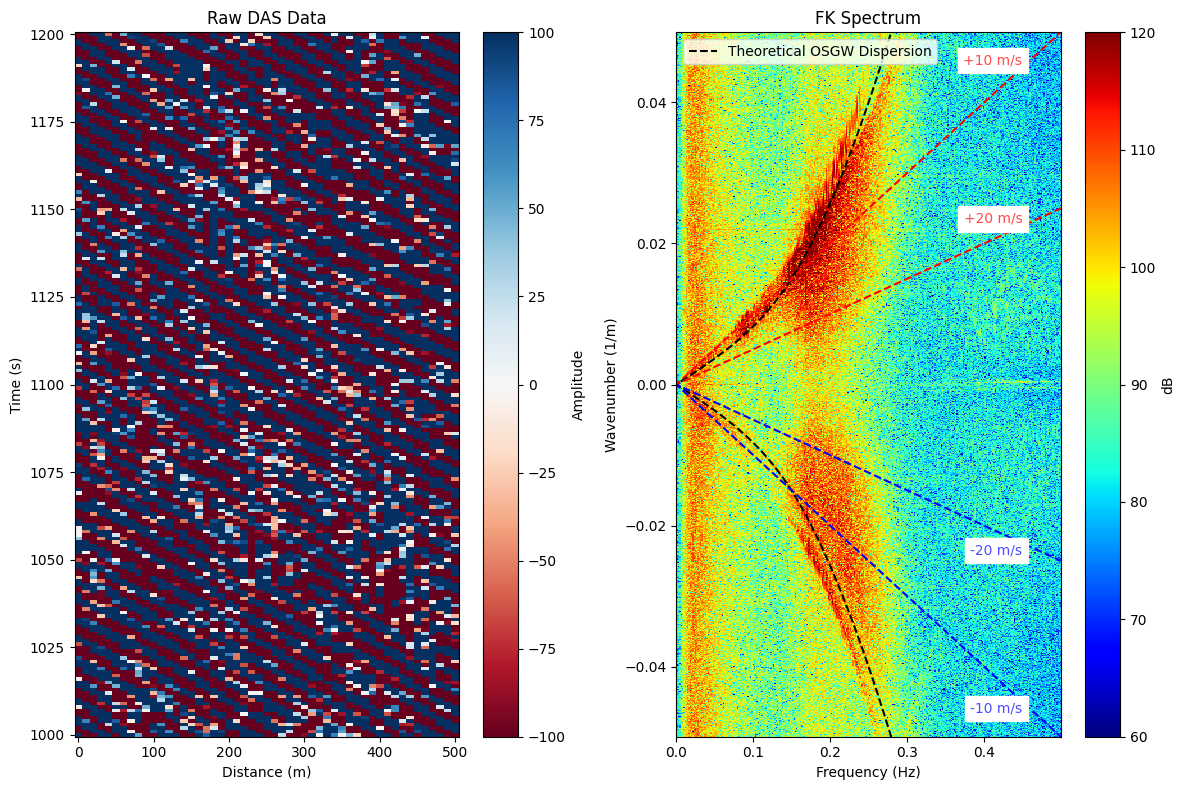

In [7]:
# Plot All Subplots
fig1, ax = plt.subplots(1, 2, figsize=(12, 8))  

# Raw DAS waveform section
v_clip = 1e2
im1 = ax[0].pcolormesh(xx, tt, data_slice.T, cmap='RdBu', vmin=-v_clip, vmax=v_clip, shading='auto')
ax[0].set_xlabel('Distance (m)')
ax[0].set_ylabel('Time (s)')
ax[0].set_title('Raw DAS Data')
plt.colorbar(im1, ax=ax[0], label='Amplitude')

# FK spectrum
im2 = ax[1].pcolormesh(freqs, wavenumbers, fk_spectrum_db, cmap='jet', vmin=60, vmax=120, shading='auto')
ax[1].plot(f_theory, wavenumbers, 'k--', label='Theoretical OSGW Dispersion')
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Wavenumber (1/m)')
ax[1].set_title('FK Spectrum')
ax[1].set_xlim([0, freqs.max()])
ax[1].set_ylim([-wavenumbers.max(), wavenumbers.max()])
ax[1].legend(loc='upper left')

# Add symmetric phase velocity lines and labels
phase_vels = [10, 20] # in m/s
for c in phase_vels:
    ax[1].plot(freqs, freqs /c , color='red', linestyle='--', linewidth=1.5)
    ax[1].plot(freqs, -freqs /c, color='blue', linestyle='--', linewidth=1.5)

    # Choose a frequency near the right end of the axis to place the labels
    freq_label_pos = freqs[int(len(freqs)*0.95)]

    # Label for positive velocity line
    ax[1].text(freq_label_pos, freq_label_pos / c, f'+{c} m/s', color='red',
               fontsize=10, verticalalignment='bottom', horizontalalignment='right',
               backgroundcolor='white', alpha=0.7)
    
    # Label for negative velocity line
    ax[1].text(freq_label_pos, -freq_label_pos / c, f'-{c} m/s', color='blue',
               fontsize=10, verticalalignment='top', horizontalalignment='right',
               backgroundcolor='white', alpha=0.7)

plt.colorbar(im2, ax=ax[1], label='dB')

fig1.tight_layout()

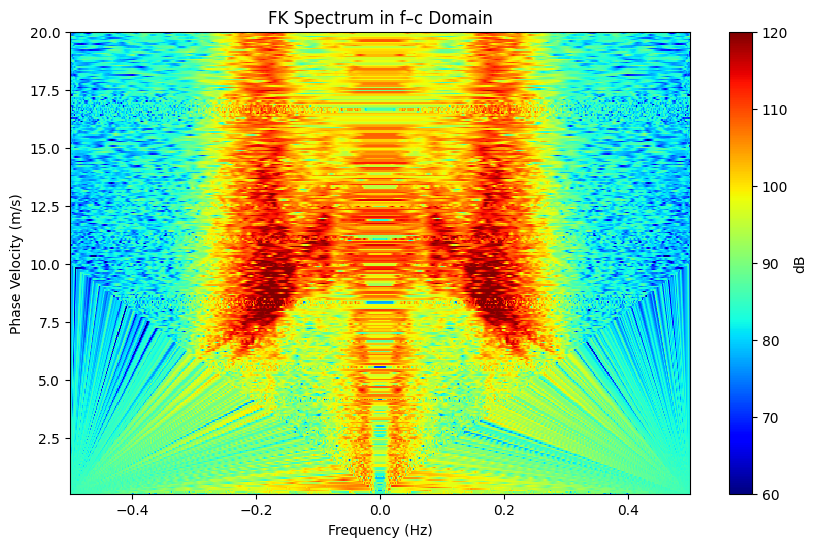

In [8]:
# Convert to f-c domain

from scipy.interpolate import griddata

# Create meshgrid for frequency and wavenumber
F, K = np.meshgrid(freqs, wavenumbers)

# Calculate phase velocity matrix
C = np.divide(F, K, out=np.zeros_like(F), where=K != 0)

# Flatten arrays for interpolation
points = np.vstack((F.flatten(), C.flatten())).T
values = fk_spectrum_db.flatten()

# Define new regular grid for (f, c)
f_new = freqs
c_min, c_max = 0.1, 20  # phase velocity limits in m/s
c_new = np.linspace(c_min, c_max, 300)
F_new, C_new = np.meshgrid(f_new, c_new)

# Interpolate FK spectrum onto (f, c) grid
fk_fc = griddata(points, values, (F_new, C_new), method='linear', fill_value=np.nan)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

im3 = ax.pcolormesh(F_new, C_new, fk_fc, shading='auto', cmap='jet', vmin=60, vmax=120)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Phase Velocity (m/s)')
ax.set_title('FK Spectrum in f–c Domain')
ax.set_ylim(c_min, c_max)
plt.colorbar(im3, ax=ax, label='dB')
plt.show()

In [9]:
# Spectrum vs Distance

# Compute FFT for each channel individually
n_freqs = ns // 2 + 1  # One-sided FFT output
spectrum = np.zeros((nx, n_freqs))

for i in range(nx):
    spectrum[i, :] = 20 * np.log10(np.abs(np.fft.rfft(data[i, :])))

# Frequency axis
f_rfft = np.fft.rfftfreq(ns, d=1. / fs) # Real-valued Fast Fourier Transform

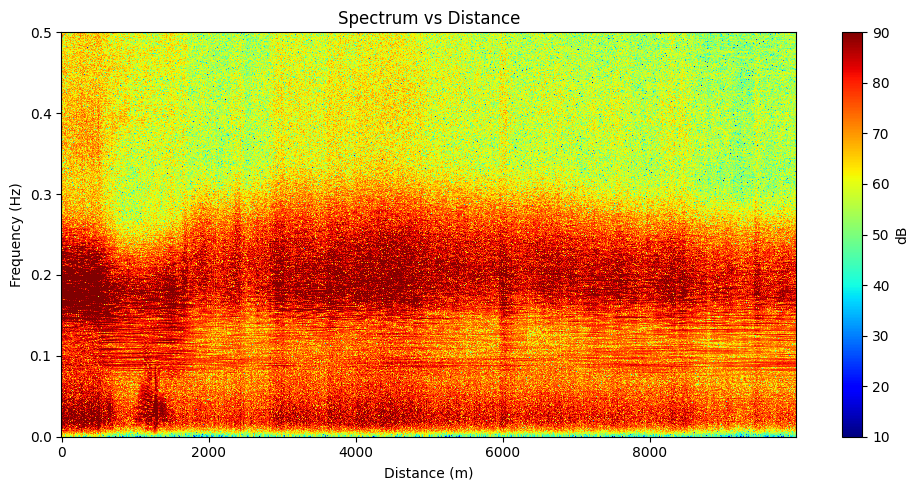

In [10]:
# Frequency Spectrum vs Distance 
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
im4 = ax.pcolormesh(x, f_rfft, spectrum.T, cmap='jet', vmin=10, vmax=90, shading='auto')
ax.set_xlabel('Distance (m)')
ax.set_ylabel('Frequency (Hz)')
ax.set_title('Spectrum vs Distance')
plt.colorbar(im4, ax=ax, label='dB')

fig.tight_layout()
plt.show()

In [35]:
# Perform SVD on f-k domain

from numpy.linalg import svd

# Compute FK spectrum and magnitude
fk_spectrum = np.fft.fftshift(np.fft.fft2(data_fk))
fk_mag = np.abs(fk_spectrum)

# Perform SVD on magnitude
U, S, Vh = svd(fk_mag, full_matrices=False)

# Select number of dominant modes to keep
n_modes = 200  
S_filtered = np.zeros_like(S)
S_filtered[:n_modes] = S[:n_modes]

# Reconstruct filted magnitude
fk_mag_filtered = np.dot(U * S_filtered, Vh)

# Recombine with original phase
fk_phase = np.angle(fk_spectrum)
fk_filtered = fk_mag_filtered * np.exp(1j * fk_phase)

# Convert filtered FK spectrum to dB scale for visualization
fk_filtered_db = 20 * np.log10(np.abs(fk_filtered) + 1e-12)  # avoid log(0)

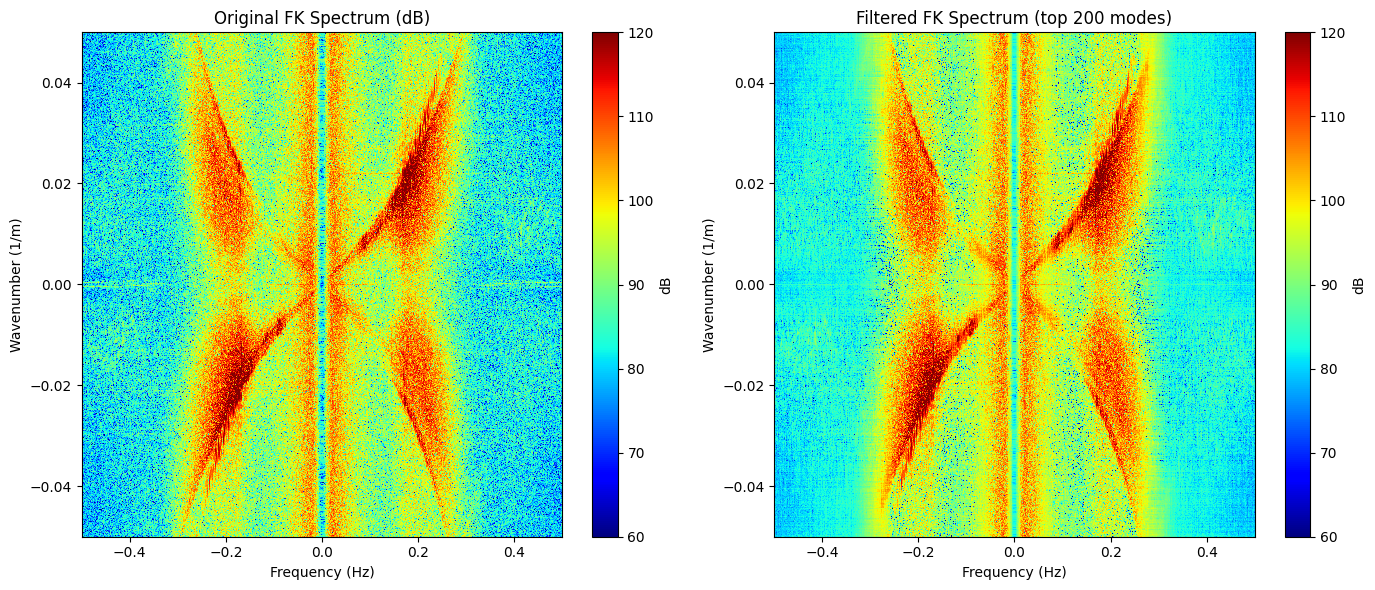

In [36]:
# Plot original vs filtered FK spectrum side-by-side
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Original FK spectrum
im0 = axs[0].pcolormesh(freqs, wavenumbers, fk_spectrum_db, cmap='jet', shading='auto', vmin=60, vmax=120)
axs[0].set_title('Original FK Spectrum (dB)')
axs[0].set_xlabel('Frequency (Hz)')
axs[0].set_ylabel('Wavenumber (1/m)')
plt.colorbar(im0, ax=axs[0], label='dB')

# Filtered FK spectrum
im1 = axs[1].pcolormesh(freqs, wavenumbers, fk_filtered_db, cmap='jet', shading='auto', vmin=60, vmax=120)
axs[1].set_title(f'Filtered FK Spectrum (top {n_modes} modes)')
axs[1].set_xlabel('Frequency (Hz)')
axs[1].set_ylabel('Wavenumber (1/m)')
plt.colorbar(im1, ax=axs[1], label='dB')

plt.tight_layout()
plt.show()